<img src="https://drive.google.com/uc?export=view&id=1wYSMgJtARFdvTt5g7E20mE4NmwUFUuog" width="200">

[![Build Fast with AI](https://img.shields.io/badge/BuildFastWithAI-GenAI%20Bootcamp-blue?style=for-the-badge&logo=artificial-intelligence)](https://www.buildfastwithai.com/genai-course)
[![EduChain GitHub](https://img.shields.io/github/stars/satvik314/educhain?style=for-the-badge&logo=github&color=gold)](https://github.com/satvik314/educhain)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1SRAFllEx_kFdy_FXXNzaQarnd6s5Xr20?usp=sharing)
## Master Generative AI in 8 Weeks
**What You'll Learn:**
- Build with Latest LLMs
- Create Custom AI Apps
- Learn from Industry Experts
- Join Innovation Community
Transform your AI ideas into reality through hands-on projects and expert mentorship.
[Start Your Journey](https://www.buildfastwithai.com/genai-course)
*Empowering the Next Generation of AI Innovators

<div style="display: flex; align-items: center; gap: 40px;">

<img src="https://miro.medium.com/v2/resize:fit:1400/1*MU3ZjY0IMHdE0SCu57i5sA.gif" width="200">


<div>
  <h2>Agent Development Kit</h2>
  <p>Agent Development Kit (ADK) is a flexible and modular framework for developing and deploying AI agents. While optimized for Gemini and the Google ecosystem, ADK is model-agnostic, deployment-agnostic, and is built for compatibility with other frameworks. ADK was designed to make agent development feel more like software development, to make it easier for developers to create, deploy, and orchestrate agentic architectures that range from simple tasks to complex workflows.</p>

###✅ Installing Required Packages

In [ ]:
# 🛠️ Step 1: Install Required Libraries
!pip install google-adk yfinance --quiet

####Setup API Keys

In [ ]:
# 🔐 Step 2: Set Up API Key Securely
from google.colab import userdata
import os

os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "0"  # Disable VertexAI usage for local Gemini

###🧩 Imports and Dependencies

In [ ]:
# 📦 Step 3: Import Core Libraries
from google.adk.agents import Agent, LlmAgent
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.adk.tools.tool_context import ToolContext
from google.adk.tools import google_search
from google.adk.tools.base_tool import BaseTool
from google.genai import types
from typing import Dict, Any, Optional
from pydantic import BaseModel, Field
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import yfinance as yf

###Define Basic Agent

In [ ]:
basic_agent = Agent(
    name="basic_agent",
    model="gemini-2.0-flash",
    description="A simple agent that answers questions",
    instruction="""
    You are a helpful stock market assistant. Be concise.
    If you don't know something, just say so.
    """
)

###Tool Agent: Stock Price Tool

In [ ]:
def get_stock_price(ticker: str):
    stock = yf.Ticker(ticker)
    price = stock.info.get("currentPrice", "Price not available")
    return {"price": price, "ticker": ticker}

tool_agent = Agent(
    name="tool_agent",
    model="gemini-2.0-flash",
    description="A simple agent that gets stock prices",
    instruction="""
    You are a stock price assistant. Always use the get_stock_price tool.
    Include the ticker symbol in your response.
    """,
    tools=[get_stock_price],
)

###Stateful Agent: Remember Recent Searches

In [ ]:
def get_stock_price_stateful(ticker: str, tool_context: ToolContext):
    stock = yf.Ticker(ticker)
    price = stock.info.get("currentPrice", "Price not available")

    if "recent_searches" not in tool_context.state:
        tool_context.state["recent_searches"] = []

    recent_searches = tool_context.state["recent_searches"]
    if ticker not in recent_searches:
        recent_searches.append(ticker)
        tool_context.state["recent_searches"] = recent_searches

    return {"price": price, "ticker": ticker}

stateful_agent = Agent(
    name="stateful_agent",
    model="gemini-2.0-flash",
    description="An agent that remembers recent searches",
    instruction="""
    You are a stock price assistant. Use the get_stock_price tool.
    I'll remember your previous searches and can tell you about them if you ask.
    """,
    tools=[get_stock_price_stateful],
)

###Multi-Tool Agent: Info + Graph

In [ ]:
def get_stock_info(ticker: str):
    stock = yf.Ticker(ticker)
    return {
        "ticker": ticker,
        "company_name": stock.info.get("shortName", "Name not available"),
        "sector": stock.info.get("sector", "Sector not available")
    }

def plot_stock_graph(ticker: str):
    df = yf.download(ticker, period="1mo", interval="1d")
    plt.figure(figsize=(10, 4))
    plt.plot(df.index, df['Close'], label=f"{ticker} Price")
    plt.title(f"{ticker} - Past 1 Month Stock Price")
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return {"message": f"Displayed price graph for {ticker}"}

multi_tool_agent = Agent(
    name="multi_tool_agent",
    model="gemini-2.0-flash",
    description="An agent with multiple stock information tools",
    instruction="""
    You are a stock information assistant. You have tools to:
    - Get stock prices
    - Get company info
    - Plot a stock graph
    """,
    tools=[get_stock_price_stateful, get_stock_info, plot_stock_graph],
)


###Structured Output Agent

In [ ]:
class StockAnalysis(BaseModel):
    ticker: str = Field(description="Stock symbol")
    recommendation: str = Field(description="Buy or Sell recommendation")

def get_stock_data_for_prompt(ticker):
    stock = yf.Ticker(ticker)
    return stock.info.get("currentPrice", 0), stock.info.get("targetMeanPrice", 0)

structured_agent = LlmAgent(
    name="structured_agent",
    model="gemini-2.0-flash",
    description="An agent with structured output",
    instruction="""
    You are a stock advisor. Analyze the stock ticker provided by the user.
    Return Buy or Sell recommendation in JSON format.
    If target price > current price: recommend Buy. Otherwise: recommend Sell.
    """,
    output_schema=StockAnalysis,
    output_key="stock_analysis"
)


###Callback Agent

In [ ]:
def get_stock_data(ticker: str, tool_context: ToolContext):
    stock = yf.Ticker(ticker)
    price = stock.info.get("currentPrice", 0)
    if "tool_usage" not in tool_context.state:
        tool_context.state["tool_usage"] = {}
    return {"ticker": ticker, "price": price}

def before_tool_callback(tool: BaseTool, args: Dict[str, Any], tool_context: ToolContext) -> Optional[Dict]:
    if "tool_usage" not in tool_context.state:
        tool_context.state["tool_usage"] = {}
    tool_usage = tool_context.state["tool_usage"]
    tool_usage[tool.name] = tool_usage.get(tool.name, 0) + 1
    tool_context.state["tool_usage"] = tool_usage
    print(f"[LOG] Running tool: {tool.name}")
    return None

def after_tool_callback(tool: BaseTool, args: Dict[str, Any], tool_context: ToolContext, tool_response: Dict) -> Optional[Dict]:
    print(f"[LOG] Tool {tool.name} completed")
    return None

callback_agent = Agent(
    name="callback_agent",
    model="gemini-2.0-flash",
    description="An agent with callbacks",
    instruction="""
    You are a stock assistant. Use get_stock_data tool to check stock prices.
    This agent keeps track of how many times tools have been used.
    """,
    tools=[get_stock_data],
    before_tool_callback=before_tool_callback,
    after_tool_callback=after_tool_callback,
)


###Session Setup and Runner Configuration

In [ ]:
APP_NAME = "financial_agent"
USER_ID = "user_001"
SESSION_ID = "session_001"

session_service = InMemorySessionService()
await session_service.create_session(app_name=APP_NAME, user_id=USER_ID, session_id=SESSION_ID)

runner = Runner(agent=multi_tool_agent, app_name=APP_NAME, session_service=session_service)


###Async Execution Handler

In [ ]:
async def call_agent_async(query: str, runner, user_id: str, session_id: str):
    print(f"\n>>> User Query: {query}")
    content = types.Content(role="user", parts=[types.Part(text=query)])
    final_response = "Agent did not respond."

    async for event in runner.run_async(user_id=user_id, session_id=session_id, new_message=content):
        if event.is_final_response():
            if event.content and event.content.parts:
                final_response = event.content.parts[0].text
            break

    display(Markdown(f"### 🤖 Agent Response\n\n{final_response}"))


###Run Example Query

In [ ]:
await call_agent_async("What is the current price and sector of TSLA?", runner, USER_ID, SESSION_ID)


>>> User Query: What is the current price and sector of TSLA?


### 🤖 Agent Response

The current price of TSLA is $315.35 and it is in the Consumer Cyclical sector.



>>> User Query: Plot the stock price graph for TSLA


/tmp/ipython-input-51-3473042997.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="1mo", interval="1d")
[*********************100%***********************]  1 of 1 completed


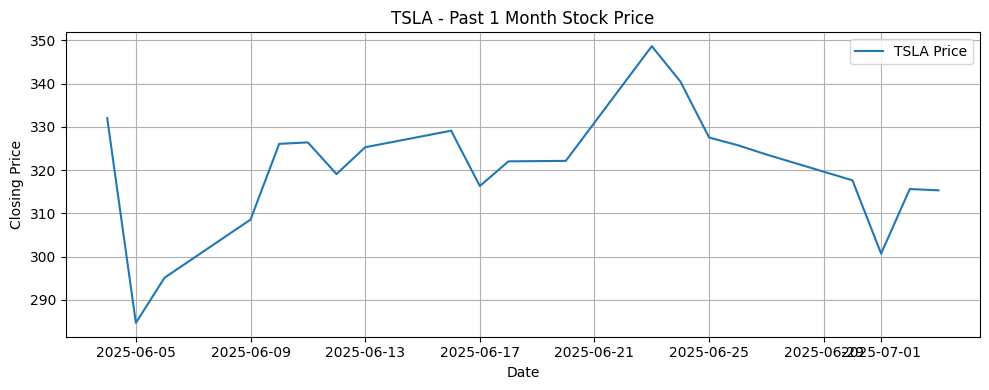

### 🤖 Agent Response

OK. I have plotted the price graph for TSLA.


In [ ]:
await call_agent_async("Plot the stock price graph for TSLA", runner, USER_ID, SESSION_ID)

In [ ]:
await call_agent_async("What is the current price and sector of NVDA?", runner, USER_ID, SESSION_ID)


>>> User Query: What is the current price and sector of NVDA?


### 🤖 Agent Response

The current price of NVDA is $159.34 and it is in the Technology sector.


>>> User Query: Plot the stock price graph for NVDA


/tmp/ipython-input-51-3473042997.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="1mo", interval="1d")
[*********************100%***********************]  1 of 1 completed


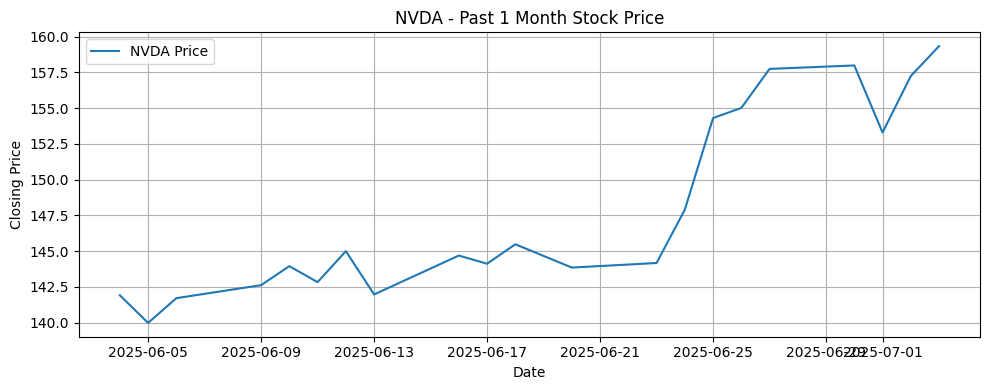

### 🤖 Agent Response

OK. I have plotted the price graph for NVDA.


In [ ]:
await call_agent_async("Plot the stock price graph for NVDA", runner, USER_ID, SESSION_ID)